# Introduction
This notebook checks your STScI panCAKE (panCAKE) installation, and provides information on how to install panCAKE on your system, including all necessary additional python modules. It covers:
* [Testing a current panCAKE installation](#Testing-PanCAKE-Installation)
* [Instructions on installing panCAKE via Anaconda and Astroconda](#Installing-PanCAKE-with-Astroconda)
* [Instructions on installing panCAKE with Anaconda but without Astroconda](#Installing-PanCAKE-with-Anaconda)
* [Troubleshooting Error Messages](#Troubleshooting-Installation)

## Testing PanCAKE Installation
This section will attempt to import panCAKE and run a default calculation with it, as well as hopefully provide information on what the problem is if something fails.

First, the script will attempt to import panCAKE:

In [1]:
import os, pkg_resources

try:
    import jwst_pancake as pancake
    print("PanCAKE Has been imported successfully!")
    print("You have PanCAKE version {} isntalled".format(pancake.__version__))
    import pandeia.engine
    print("Pandeia is version {}".format(pkg_resources.get_distribution("pandeia.engine").version))
    pandeia_version_file = os.path.join(os.environ["pandeia_refdata"], "VERSION_PSF")
    with open(pandeia_version_file, 'r') as inf:
        pandeia_data_version = inf.readline().strip()
    print("You have version {} of the pandeia data".format(pandeia_data_version))
    import webbpsf
    print("Webbpsf is version {}".format(webbpsf.__version__))
    webbpsf_version_file = os.path.join(os.environ["WEBBPSF_PATH"], "version.txt")
    with open(webbpsf_version_file, 'r') as inf:
        webbpsf_data_version = inf.readline().strip()
    print("You have version {} of the webbpsf data".format(webbpsf_data_version))
except Exception as e:
    print("An error occurred when importing pancake.")
    if str(e) == "No module named stsci_pancake":
        print("The pancake module is not installed.")
    elif str(e) == "No module named 'astropy.analytic_functions'":
        print("Until pandeia is compatible with python 3, pancake must be run under python 2")
    elif str(e) == "ERROR - you need to set the environment variable pandeia_refdata or calculations will not work":
        print("Pancake requires the environment variables PYSYN_CDBS, WEBBPSF_PATH and pandeia_refdata.")
    elif str(e) == "RuntimeError: Python is not installed as a framework. The Mac OS X backend will not be able to function correctly if Python is not installed as a framework. See the Python documentation for more information on installing Python as a framework on Mac OS X. Please either reinstall Python as a framework, or try one of the other backends. If you are using (Ana)Conda please install python.app and replace the use of 'python' with 'pythonw'. See 'Working with Matplotlib on OSX' in the Matplotlib FAQ for more information.":
        print("Pancake may require the matplotlib backend to be set to 'agg'")
    elif "No module named" in str(e):
        module_name = str(e)[16:]
        print("Pancake requires module {}".format(module_name))
    else:
        print("The following exception was raised: {}".format(e))
    raise e

PanCAKE Has been imported successfully!
You have PanCAKE version 1.0.0rc2 isntalled
Pandeia is version 1.5.1
You have version 1.5.1 of the pandeia data
Webbpsf is version 0.9.1.dev28+g8216e64
You have version 0.9.0 of the webbpsf data


If the above section, when run, produces the output "PanCAKE has been imported successfully!" then you have panCAKE installed. In that case, run the next section to test whether panCAKE can run a simple default calculation. 

If the above section did not succeed, then you may have encountered one of the following exceptions:
* [The Pancake Module is not Installed](#The-pancake-module-is-not-installed)
* [Pancake requires module](#Pancake-requires-module)
* [Pancake requires the environment variables PYSYN_CDBS, WEBBPSF_PATH and pandeia_refdata.](#Pancake-environment)
* [Pancake may require the matplotlib backend to be set to 'agg'](#Matplotlib-agg)
* [Until pandeia is compatible with python 3, pancake must be run under python 2](#Pandeia-python-3)

Otherwise, please go to [the STScI JWST Helpdesk](https://stsci.service-now.com/jwst) and open an issue, being sure to mention that you are unable to install panCAKE, and providing the exception text above in the issue.

## Known Compatible Versions

PanCAKE has been tested successfully with the following additional packages (this list is not complete):

* Python 3, Pandeia 1.2, Webbpsf 0.6, Astropy 2
* Python 3, Pandeia 1.3, Webbpsf 0.6, Astropy 3
* Python 3, Pandeia 1.3, Webbpsf 0.8, Astropy 3
* Python 3, Pandeia 1.5, Webbpsf 0.9, Astropy 4

CUSTOM PSF LIBRARY ACTIVATE!
CUSTOM PSF LIBRARY ACTIVATE!
CUSTOM PSF LIBRARY ACTIVATE!
CORONAGRAPHY SCENE CUBE ACTIVATE!
Getting nircam mask210r 1.9295999... with caching ram
 Cache Stats: CacheInfo(hits=0, misses=1, maxsize=256, currsize=1)
Getting nircam mask210r 1.9295999... with caching ram
 Cache Stats: CacheInfo(hits=0, misses=2, maxsize=256, currsize=2)
Getting nircam mask210r 1.9969999399999998... with caching ram
 Cache Stats: CacheInfo(hits=0, misses=3, maxsize=256, currsize=3)
Getting nircam mask210r 2.0643999799999997... with caching ram
 Cache Stats: CacheInfo(hits=0, misses=4, maxsize=256, currsize=4)
Getting nircam mask210r 2.13180002... with caching ram
 Cache Stats: CacheInfo(hits=0, misses=5, maxsize=256, currsize=5)
Getting nircam mask210r 2.19920006... with caching ram
 Cache Stats: CacheInfo(hits=0, misses=6, maxsize=256, currsize=6)
Getting nircam mask210r 2.2666001... with caching ram
 Cache Stats: CacheInfo(hits=0, misses=7, maxsize=256, currsize=7)
Getting nirc

Basic PanCAKE Calculation Succeeded!


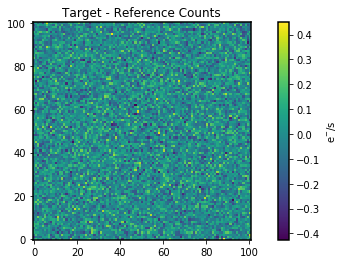

In [2]:
try:
    import matplotlib.pyplot as plt
    %matplotlib inline

    from pandeia.engine.calc_utils import build_default_calc

    config = build_default_calc('jwst', 'nircam', 'coronagraphy')

    pancake.engine.options.on_the_fly_PSFs = True
    pancake.engine.options.wave_sampling = 6
    pancake.engine.options.verbose = True # Uncomment this line to get logging output during calculation

    result = pancake.engine.calculate_subtracted(config)
    
    print("Basic PanCAKE Calculation Succeeded!")

    plt.figure(figsize=(10,4))
    plt.imshow(result['subtracted'])
    plt.title('Target - Reference Counts')
    plt.colorbar().set_label('e$^{-}$/s')
except Exception as e:
    import traceback
    print("An error occurred during the calculation.")
    print("Exception text: {}".format(e))
    print("Exception traceback:")
    traceback.print_tb(e.__traceback__)

If the above section, when run, produces the output text "Basic PanCAKE Calculation Succeeded!" and produces the image of a target-reference subtracted scene, then your copy of panCAKE is working successfully.

If the above section did not succeed, then you may have encountered one of the following exceptions:

* [Not sure what to do with a pupil of that type:<type 'unicode'>](#Unicode-pupil)

Otherwise, please go to [the STScI JWST Helpdesk](https://stsci.service-now.com/jwst) and open an issue, being sure to mention that you are able to install but unable to run panCAKE, and providing the exception text above in the issue.

## Installing PanCAKE with Astroconda


### PanCAKE Installation

For information on installing astroconda, [see the astroconda websites](https://astroconda.readthedocs.io/en/latest/). Install astroconda, and then create an astroconda environment in python 3.

Once you have activated your astroconda environment, and [ensured that you have environment variables pointing to the appropriate reference data directories](#Pancake-environment), you should then download panCAKE [from GitHub](https://github.com/spacetelescope/pandeia-coronagraphy). For example, you can clone the panCAKE repository by entering the following on the command line from within your astroconda environment:

```
git clone https://github.com/spacetelescope/pandeia-coronagraphy.git
```

Then, use pip to perform a local installation of panCAKE by typing:

```
pip install pandeia-coronagraphy/
```

## Installing PanCAKE with Anaconda

If you do not have fftw installed, and do not wish to install it yourself, you should add [conda-forge](https://conda-forge.org/#about) to your available channels by typing:

```
conda config --add channels conda-forge
```

at the command line.

### Python 3

Begin by creating an anaconda environment, for example by entering:

```
conda create -n pancake python=3 fftw
```

at the command line. Then download panCAKE from [GitHub](https://github.com/spacetelescope/pandeia-coronagraphy), or with:

```
git clone https://github.com/spacetelescope/pandeia-coronagraphy.git
```

followed by a local pip installation with

```
pip install pandeia-coronagraphy/
```

which will automatically install (almost) all of the needed python packages. Pandeia has an undeclared dependency on pyfftw, so you will also need to type:

```
pip install pyfftw
```

at the command line to install pyfftw. Then ensure that [your environment variables are set up](#Pancake-environment), and you should be able to run panCAKE.


## Troubleshooting Installation

This section includes common errors you might encounter when testing your installation, along with ways to resolve those issues.

### The pancake module is not installed

**WARNING**: installing pancake from pip via ``pip install pancake`` will produce an entirely different module also named pancake, so *please* do not attempt to resolve this error by installing pancake with pip.

If you encounter this error, then the pancake module is not installed. 

In order to install pancake, first go to <https://github.com/spacetelescope/pandeia-coronagraphy>, click the "Clone or Download" button, and click the clipboard icon to copy the URL provided there. Then go to a command line, and type ``git clone `` followed by pasting in the URL (typing ``git clone https://github.com/spacetelescope/pandeia-coronagraphy.git`` should work to install pancake's master branch). Once pancake has been installed, try the first section again. If there are any errors during installation, please go to [the STScI JWST Helpdesk](https://stsci.service-now.com/jwst) and open an issue, being sure to mention that you are unable to install panCAKE, and providing the error that you got during installation.

### Pancake requires module

If you encounter this error, then the named module is required by panCAKE but not present.

In order to solve this, install the named module with ``pip install name`` where "name" is the missing module.

### Pancake environment

PanCAKE uses a number of other packages which require external data files to work. These include pandeia (which requires its own data files and the CDBS data files) and webbpsf.

* The CDBS data is found [in the pysynphot documentation][cdbs_data] and are set using the PYSYN_CDBS environment
  variable
* The webbpsf data is found [at the webbpsf download link][webbpsf_data] and is set using the WEBBPSF_PATH 
  environment variable
* The pandeia data is found [at the pandeia PyPi page][pandeia_data] and is set using the pandeia_refdata environment 
  variable

In order to set these environment variables, you can do one of the following:

* In anaconda/astroconda, [edit your activate and deactivate scripts](#Conda-activation-scripts)
* By setting your ``.profile`` file to include the needed environment variables
* By setting the environment variables in your script [using the os module](#OS-module-environment)

### Matplotlib Agg

On macOS X, the use of matplotlib's aqua backend requires python to be installed as a framework (see [Working with Matplotlib on OS X](https://matplotlib.org/faq/osx_framework.html) for more information). If you encounter this problem, there are a number of possible solutions:

* Use a python framework installation as described in the matplotlib documentation
* Run pancake from a notebook
* Set the matplotlib backend to 'agg' either in python or in a matplotlib configuration file

For the last of these options, in order to set the backend within python, you should import matplotlib along with the line ``matplotlib.use('agg')`` *before* importing panCAKE. In order to use a configuration file, create a matplotlib configuration file (see [the matplotlib documentation](https://matplotlib.org/contents.html) for how to do this) and, if necessary, set an environment variable to point to the configuration file. See [the pancake environment](#Pancake-environment) section for more information on how to do this.

### Unicode pupil

This error indicates that you have webbpsf 0.6 installed alongside poppy 0.7. These two versions are mutually incompatible, and the solution is to replace poppy 0.7 with poppy 0.6. This can be done by typing:

```
pip install poppy==0.6.1
```

at the command line.

### Pandeia python 3

At the moment, the publicly available version of pandeia attempts to import an astropy module which is deprecated in astropy 3 (the default version of astropy installed under python 3). Because the pandeia installer does not specify which version of astropy should be installed, if installing pandeia or pancake under python 3 you will likely end up with the wrong version of astropy. In order to fix this, you can either:

* Install astropy version 2
* Run panCAKE under python 2

This is likely to be fixed in the next public release of pandeia.

### OS Module Environment

The python ``os`` module can be used to set environment variables before pancake (or one of its dependencies) is imported. The following code shows an example:

```python
import os

os.environ['PYSYN_CDBS'] = '$HOME/data/cdbs'
os.environ['WEBBPSF_PATH'] = '$HOME/data/webbpsf-data'
os.environ['pandeia_refdata'] = '$HOME/data/pandeia_data'
```

In the above example, you are assumed to have a directory named ``data`` in your home directory, which contains the CDBS data tree (named ``cdbs``), the webbpsf data tree (named ``webbpsf-data``), and the pandeia data tree (named ``pandeia_data``).

### Conda Activation Scripts

Anaconda/Astroconda allows for a shell script to be run when a particular environment is activated or deactivated. The activation script should be located at ``/path/to/anaconda/envs/your_env/etc/conda/activate.d/env_vars.sh``, whilst the deactivation script should be located at ``/path/to/anaconda/envs/your_env/etc/conda/deactivate.d/env_vars.sh``. In both cases, ``/path/to/anaconda/`` is the path to your anaconda installation, and ``your_env`` is the name of the environment you are using to run panCAKE.

#### Activation

The activation script sets the values of environment variables. For example, for a pancake installation where you have a directory named "data" in your home directory, and that directory contains the CDBS data tree (named ``cdbs``), the webbpsf data tree (named ``webbpsf-data``) and the pandeia data tree (named ``pandeia_data``), the activation ``env_vars.sh`` script would be:

```sh
#!/bin/sh

export PYSYN_CDBS=$HOME/data/cdbs
export WEBBPSF_PATH=$HOME/data/webbpsf-data
export pandeia_refdata=$HOME/data/pandeia_data
```

#### Deactivation

The deactivation script should unset all of the environment variables set by the activation script. So, for the above activation script, the deactivation ``env_vars.sh`` script would be:

```
#!/bin/sh

unset PYSYN_CDBS
unset WEBBPSF_PATH
unset pandeia_refdata
```

[cdbs_data]: https://pysynphot.readthedocs.io/en/latest/index.html#pysynphot-installation-setup
[webbpsf_data]: https://webbpsf.readthedocs.io/en/stable/installation.html
[pandeia_data]: https://pypi.org/project/pandeia.engine/